# NER with Data from LabelStudio

<div>
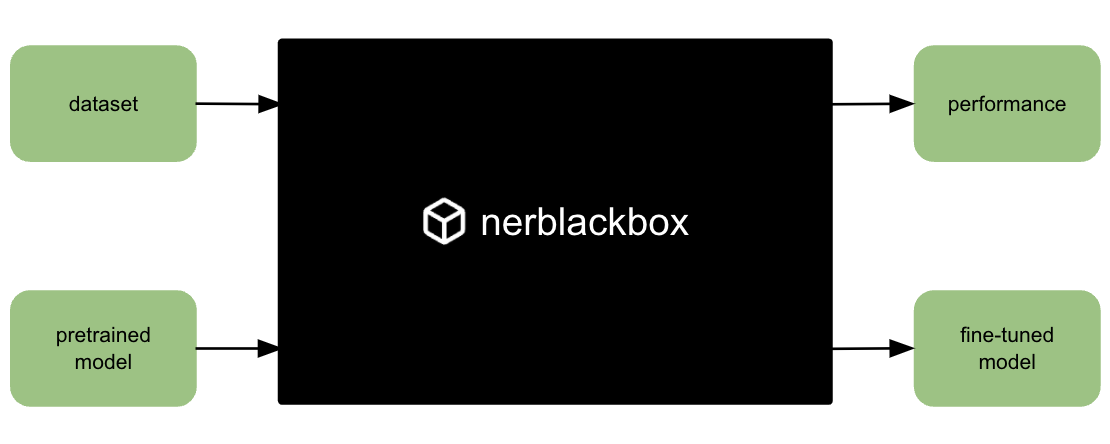
</div>

# Preparations

### nerblackbox: Create a Store for data, models, results etc.

In [ ]:
# import main classes from nerblackbox
from nerblackbox import AnnotationTool, Store, Dataset, Experiment, Model

In [ ]:
Store.create()

In [ ]:
# view the content of the newly created folder
!ls store

### LabelStudio: Run Server & Connect

In [ ]:
# check that LabelStudio server is running
!curl http://localhost:8081/health

In [ ]:
# show configuration file for LabelStudio
!cat labelstudio.ini

In [ ]:
# connect to LabelStudio
annotation_tool = AnnotationTool.from_config(dataset_name="ehealth_kd", config_file=f"labelstudio.ini")

assert annotation_tool.connected is True

# 0. Create human-annotated data

In [ ]:
from utils import prepare_raw_data, upload_raw_data, simulate_annotation

### 0a. Prepare raw data

In [ ]:
prepare_raw_data("ehealth_kd")

In [ ]:
# check that the files exist
!ls ./store/datasets/ehealth_kd/*_data.jsonl

In [ ]:
# inspect the first row of "annotated_data.jsonl"
!head -n 1 ./store/datasets/ehealth_kd/annotated_data.jsonl

### 0b. Upload raw data

In [ ]:
upload_raw_data("ehealth_kd", annotation_tool)

### 0c. Simulate annotation

In [ ]:
simulate_annotation("ehealth_kd", annotation_tool)

In [ ]:
# inspect the first row of "annotated_data.jsonl"
!head -n 1 ./store/datasets/ehealth_kd/annotated_data.jsonl

# 1. Download human-annotated data

In [ ]:
annotation_tool.download(project_name="annotated_data")

In [ ]:
# inspect the first row of "annotated_data.jsonl"
!head -n 1 ./store/datasets/ehealth_kd/annotated_data.jsonl

# 2. Train a model

### 2a. Prepare data

In [ ]:
file_path = annotation_tool.get_file_path(project_name="annotated_data")
dataset = Dataset.from_file("ehealth_kd", file_path)
dataset.split()

### 2b. train

In [ ]:
# define an experiment
experiment = Experiment("labelstudio", dataset="ehealth_kd", model="mrm8488/electricidad-base-discriminator")

In [ ]:
# run the experiment (this will take at least a few minutes)
experiment.run()

In [ ]:
# inspect the model performance
experiment.get_result(label="micro", level="entity", metric="f1", phase="test")

# 3. Evaluate the model

In [ ]:
# load the model
model = Model.from_experiment("labelstudio")

In [ ]:
# evaluate and get the micro-averaged f1 score
evaluation_dict = model.evaluate_on_dataset("ehealth_kd", "jsonl", phase="test")
evaluation_dict["micro"]["entity"]["f1"]

# 4. Apply the model

### 4a. Single example

In [ ]:
# predict on single example sentence
model.predict("La vitamina D ayuda al cuerpo a absorber el calcio.")

### 4b. Raw data

In [ ]:
# download the raw data
annotation_tool.download(project_name="raw_data")

In [ ]:
# let the model annotate the raw data 
input_file = annotation_tool.get_file_path(project_name="raw_data")
output_file = annotation_tool.get_file_path(project_name="raw_data_model_annotated")

model.predict_on_file(input_file, output_file)

In [ ]:
# inspect the first row of "raw_data_model_annotated.jsonl"
!head -n 1 ./store/datasets/ehealth_kd/raw_data_model_annotated.jsonl

# 5. Upload model-annotated data

In [ ]:
# upload the model-annotated data
annotation_tool.upload(project_name="raw_data_model_annotated")